# 1. Example: Creating a Model in DataAssimBench

In this notebook, we'll introduce the basics of how to create a model object in DataAssimBench and use generated data to train and evaluate it. We'll use Lorenz63 data generator and a reservoir computing model

### Part I: Import dabench.model

The "model sub-package is dabench's interface for creating and using models.

In [1]:
from dabench import model, data, vector
import numpy as np

In [2]:
# Running help on data shows that available data classes (under the heading "CLASSES")
help(model)

Help on package dabench.model in dabench:

NAME
    dabench.model

PACKAGE CONTENTS
    _model
    _reservoir_computing

CLASSES
    builtins.object
        dabench.model._model.Model
    
    class Model(builtins.object)
     |  Model(system_dim=None, time_dim=None, delta_t=None, model_obj=None)
     |  
     |  Base class for Model object
     |  
     |  Attributes:
     |      system_dim (int): system dimension
     |      time_dim (int): total time steps
     |      delta_t (float): the timestep of the model (assumed uniform)
     |      model_obj (obj): underlying model object, e.g. pytorch neural network.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, system_dim=None, time_dim=None, delta_t=None, model_obj=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      diction

### Part II: Train Reservoir Computing Model

We'll use a Reservoir Computing model, a twist on a recurrent neural network. The "reservoirpy" package makes it easy to build one of these models. To install, use:

`pip install reservoirpy`


In [58]:
import reservoirpy
import matplotlib.pyplot as plt

In [59]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=1000, lr=0.1, sr=0.8)
readout = Ridge(output_dim=3, ridge=1e-4)
esn = reservoir >> readout

In [60]:
l63 = data.Lorenz63()
l63.generate(n_steps=20000)

In [61]:
train = l63.values[:18000]
val = l63.values[18000:19000]
test = l63.values[19000:]

In [62]:
esn.fit(train[:-1], train[1:], warmup=200)

Running Model-5:   0%|                                                                                                                                                           | 0/1 [00:00<?, ?it/s]
Running Model-5: 167it [00:00, 1666.64it/s]                                                                                                                                                            
Running Model-5: 349it [00:00, 1755.03it/s]
Running Model-5: 525it [00:00, 1741.14it/s]
Running Model-5: 700it [00:00, 1718.10it/s]
Running Model-5: 872it [00:00, 1713.84it/s]
Running Model-5: 1053it [00:00, 1744.51it/s]
Running Model-5: 1228it [00:00, 1738.53it/s]
Running Model-5: 1402it [00:00, 1714.07it/s]
Running Model-5: 1579it [00:00, 1729.91it/s]
Running Model-5: 1763it [00:01, 1762.29it/s]
Running Model-5: 1940it [00:01, 1759.16it/s]
Running Model-5: 2116it [00:01, 1739.15it/s]
Running Model-5: 2290it [00:01, 1675.66it/s]
Running Model-5: 2459it [00:01, 1674.69it/s]
Running Model-5: 26

Fitting node Ridge-5...


'Model-5': Model('Reservoir-5', 'Ridge-5')

In [63]:
predictions = esn.run(val)

Running Model-5: 1000it [00:00, 1221.23it/s]                                                                                                                                                           


In [64]:
predictions.shape

(1000, 3)

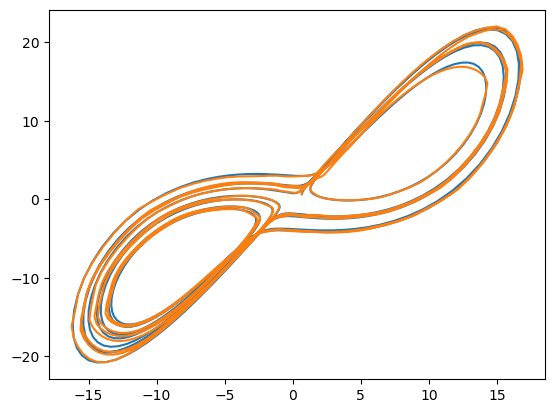

In [65]:
plt.plot(val[1:,0], val[1:,1])
plt.plot(predictions[:-1,0],predictions[:-1,1])
plt.show()



### Part III: Wrap RC model in DABench Model Object

In [66]:
class RC_model(model.Model):
    def forecast(self, state_vec):
        new_vals = esn.call(state_vec.values)
        
        new_vec = vector.StateVector(values = new_vals)
        
        return new_vec

In [67]:
rc_model = RC_model()

In [68]:
all_vals = []
state_vec = vector.StateVector(values=np.array([test[0]]))
all_vals.append(state_vec.values)
for i in range(test.shape[0]):
    state_vec = rc_model.forecast(state_vec)
    all_vals.append(state_vec.values)

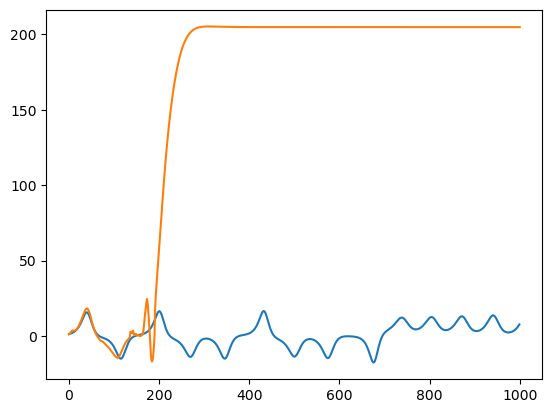

In [69]:
plt.plot(test[:,0])
plt.plot(np.array(all_vals).reshape(-1,3)[:,0])
